In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata
from sklearn.cluster import KMeans
import cartopy.crs as ccrs
import sys
from cmcrameri import cm
import netCDF4 as nc
from area import area
## For measuring area we need to identify contours
from skimage import measure
from turfpy.measurement import boolean_point_in_polygon
from geojson import Polygon
import pickle
import terra_utils
from terratools import *
import string

In [3]:
alphabet = list(string.ascii_lowercase)

#Load some different colourmaps
batlow=plt.get_cmap(cm.batlow)
seismic=plt.get_cmap(cm.roma)
vik=plt.get_cmap(cm.vik)
bamako=plt.get_cmap(cm.bamako)
hawaii=plt.get_cmap(cm.hawaii)
bam=plt.get_cmap(cm.bam)

In [4]:
def gridData(lonlat,field,interpolation='linear'):
    """Grid data ready for spherical harmonic analysis...
    requires data to be in form [lat,lon,z,field] ...
    Interpolate with 'linear', 'nearest', or 'cubic...'"""

    #Define grid shape
    grid_lat, grid_lon = np.mgrid[-90:90:180j, -180:180:360j]
    #Grid data using linear interpolation


    grid = griddata(lonlat, field, (grid_lon, grid_lat), method=interpolation)
    grid=np.nan_to_num(grid)
    grid=np.flip(grid,axis=0)
    
    return grid, grid_lon, grid_lat

In [5]:
def get_cvals(indat,layer):
    """
    Take input netcdf data for single layer
    and return c-vals
    
    param:    indat: input netCDF file
    """
    ncomps=indat.shape[1]+1
    nth_comp=1-np.sum(np.clip(indat,0,1),axis=1)
    cvals=np.zeros(ncomps)
    for c in range(ncomps):
        cvals[c]=getattr(indat,f"composition_{c+1}_c")
        
    data_depth=np.zeros(indat.shape[0]*indat.shape[-1])
    for c in range(ncomps):
        if c==ncomps-1:
            data_depth=data_depth+(nth_comp[:,layer,:]*cvals[c]).flatten()
        else:
            data_depth=data_depth+(indat[:,c,layer,:]*cvals[c]).flatten()
            
    return data_depth

In [6]:
def get_contours(pic,cont_level,grid_lat,grid_lon):
    """
    This routine takes the cluster image (pic) and uses skimage.measure to determine the outline of the given contour
    level (cont_level). The centroid of each contour is determined (get_center) and these points, along with the coordinates
    for each contour are saved to .yml files
    """
    contours_dict={}
    contz=measure.find_contours(pic,cont_level-0.01)
    

    for n, contour in enumerate(contz):
        contour_latlon=np.zeros((contour.shape))
        for i in range(contour.shape[0]): #iterate over coordinates for each contour
            contour_latlon[i,1]=grid_lat[int(contour[i,0]),0] #convert from array indices to degrees
            contour_latlon[i,0]=grid_lon[0,int(contour[i,1])]
        contours_dict[n]=contour_latlon
        # lon_c,lat_c=get_center(contour_latlon[:,0],contour_latlon[:,1]*-1) #Determine center of each contour
        # contours_cen_dict[n]={'long': str(lon_c), 'lat': str(lat_c)} #save centers to dictionary

    
    return contours_dict

In [7]:
def geo_poly(contour):
    """
    Creates a GeoJSon polygon using the coordinates of the contour provided
    """
    polygon=Polygon(
    [
        [
            (lon,lat) for lon,lat in zip(contour[:,0],contour[:,1])
        ]
    ])
    return polygon

In [8]:
def tot_area(contours):
    
    # conts=measure.find_contours(llsvps[domain][str(int(depth))]['mask'],1.-0.01)
    total_area=0.
    depth='2890'
    contbool=[]
    for n,cont in enumerate(conts): # loop over contours to get a point from each
        m=0
        point=[conts[n][0][0],conts[n][0][1]]
        tf=False
        while m < len(conts) and tf==False:   #loop over the contours to get polygons of each
            if m!=n:
                poly=geo_poly(conts[m])
                tf=boolean_point_in_polygon(point,poly) #check if point lies within any of the other contours
            m=m+1
        contbool.append(tf)

    for n,cont in enumerate(conts):
        poly=geo_poly(conts[n])
        contarea=area(poly)
        if not contbool[n] : #Contour surrounds area of llsvp
            total_area=total_area+contarea
        else:             #Contour encircles void space within llsvp
            total_area=total_area-contarea 
    
    
    
    return total_area
    

In [9]:
units={ "vs" : {"units":"km/s", "tt_name": "vs"}, 
      "vp" :  {"units":"km/s", "tt_name": "vp"}, 
      "vs_anelastic" : {"units":"km/s", "tt_name": "vs_an"}, 
      "vp_anelastic" : {"units":"km/s", "tt_name": "vp_an"}, 
      "v_bulk" : {"units":"km/s", "tt_name": "vphi"},  
      "density" :{"units":"kg/m$^{3}$", "tt_name": "density"}, 
      "radial_velocity" : {"units":"cm/yr", "tt_name": ""}, 
      "vs_av" : {"units":"%", "tt_name": "vs_av"}, 
      "vp_av" : {"units":"%", "tt_name": "vp_av"}, 
      "vs_anelastic_av" : {"units":"%", "tt_name": "vs_an_av"}, 
      "vp_anelastic_av" : {"units":"km/s", "tt_name": "vp_av_av"}, 
      "density_av" : {"units":"%", "tt_name": "density_av"}, 
      "v_bulk_av" : {"units":"%", "tt_name": "vphi_av"}, 
      "vs_prem" : {"units":"%", "tt_name": "vs_prem"}, 
      "vp_prem" : {"units":"km/s", "tt_name": "vp_prem"}, 
      "vs_anelastic_prem" : {"units":"%", "tt_name": "vs_an_prem"}, 
      "vp_anelastic_prem" : {"units":"%", "tt_name": "vp_an_prem"}, 
      "density_prem" : {"units":"%", "tt_name": "density_prem"}, 
      "viscosity" : {"units":"Pa s", "tt_name": "visc"}, 
      "temperature" : {"units":"K", "tt_name": "t"}, 
      "composition" : {"units":"C", "tt_name": "c"}, 
      "meltage"     : {"units":"Myr", "tt_name": "mage"}, 
      "ppv"         : {"units":"%", "tt_name": "ppv"}, 
     }

In [28]:
case="RCY"
dump=37
prim_type="" #add '_ceb' if testig model PRIM assuming CEB composition for C=2 material
fields=['composition','temperature','vs','meltage','density','radial_velocity','ppv'] #add whichever fields you would like to take out for the llvps
model=terra_model.read_netcdf(f'./{case}/nc_seis_{str(dump).zfill(3)}{prim_type}.nc',cat=True)
if 'meltage' or 'density' in fields: 
    modelcomp=terra_model.read_netcdf(f'./{case}/nc_comp_{str(dump).zfill(3)}.nc',cat=True)
    if "mage" not in modelcomp.field_names():
        modelcomp.set_field("mage",model.get_field("mage")) #Uncomment if meltage in nc_seis file

In [29]:
nr=len(model.get_radii())
# mindepth=2200 #minimum depth in km to find LLVPs #2200
mindepth=2200
maxdepth=2890 #maximum depth in km to find LLVPs
depths=np.linspace(2890,0,nr)
llsvp_def='cluster' #set to 'cluster' or 'limit' 
limit=-1.0
scalefac=2.0

#get indices of layer bounds
imin=np.where(np.abs(depths-mindepth)==min(np.abs(depths-mindepth)))[0][0]
imax=np.where(np.abs(depths-maxdepth)==min(np.abs(depths-maxdepth)))[0][0]

layers=np.arange(imin,imax-1,-1)

## For non-compositional histograms we need to define histogram limits
## otherwise they will change with each radial layer and so we wouldn't 
## be able to sensibly plot them. 

his_lims= {"temperature"     : { "min" : 2000, "max" : 4000},
           "vs"              : { "min" : 6.9 , "max" : 7.2} ,
           "meltage"         : { "min" : 0.  , "max" : 1.2e9},
           "density"         : { "min" : 3000, "max" : 5500},
           "ppv"             : { "min" : 0.  , "max" : 100} ,
          }

In [32]:
# if 'llsvps' not in globals():
#     llsvps={'african':{},
#            'pacific':{}
#            }
llsvps={'african':{},
       'pacific':{}
       }

#Do we want to add ppv to the terra model?
if "ppv" in fields:
    "Adding ppv to Terra Model"
    sys.path.append('./')
    import ppv

    if prim_type=="":
        prmt=None
    else:
        prmt=prim_type
    ppv.add_ppv_field(model,modelcomp,prim=prmt,intrinsic_dens=False)
    

#Surface area earth
sae = area({'type':'Polygon','coordinates':[[[-180,-90],[-180,90],[180,90],[180,-90],[-180,-90]]]})

#### Below is for calculating LLVPs using FILTERED model 
for layer in layers:
    depth=f"{str(int(depths[layer])).zfill(4)}"
    print(depth)
    data=np.genfromtxt(f"{case}/filt/oupm.S40.{case}{prim_type}.filt.{depth}.dat")
    lonlat=np.zeros((np.shape(data)[0],2))
    lonlat[:,0]=data[:,1]
    lonlat[:,1]=data[:,0]
    data_grid, grid_lon, grid_lat=gridData(lonlat,data[:,2],interpolation='linear')
####################################################################################

#### Below is for detecting LLVPs using un-filtered model
# for layer in layers:
#     depth=f"{str(int(depths[layer])).zfill(4)}"
#     print(depth)
#     av=np.average(model.get_field("vs")[layer,:])
#     data=(model.get_field("vs")[layer,:]-av)/av*100
#     lonlat=np.zeros((np.shape(model.get_lateral_points())[1],2))
#     lonlat[:,0],lonlat[:,1]=model.get_lateral_points()
#     data_grid, grid_lon, grid_lat=gridData(lonlat,data,interpolation='linear')
####################################################################################

    if llsvp_def == 'cluster':
        nclust=3
        cluster_arr=np.zeros((len(data_grid.flatten()),1))
        cluster_arr[:,0]=data_grid.flatten()


        kmeans = KMeans(n_clusters=nclust, random_state=0, n_init="auto").fit(cluster_arr)
        clust_vals = kmeans.cluster_centers_[kmeans.labels_]

        clust_vals=clust_vals.reshape(np.shape(data_grid)[0],np.shape(data_grid)[1])

        #Numerate the clusters
        cluster_pic=np.zeros((np.shape(clust_vals)[0],np.shape(clust_vals)[1]))
        for i, uval in enumerate(np.unique(clust_vals)[::-1]): #LLSVP region (low velocity) will be highest value
            mask=clust_vals[:,:]==uval
            cluster_pic=cluster_pic+(mask*i)

        #keep only the LLSVP cluster
        mask=cluster_pic!=2
        grid2=cluster_pic*~mask
    elif llsvp_def == 'limit': #use this to define LLVPs by a set limit value **INCOMPLETE**
        mask=data_grid<=limit
        

    #Simply define African and Pacific LLSVPs by longitude
    mask=(grid_lon>140)+(grid_lon<-50)                            #>130 ??
    pacific=(grid2*[mask])[0,:,:]
    african=(grid2*[~mask])[0,:,:]
    mask=african>0
    african=african-mask
    both=pacific+african #New array where 1=African and 2=Pacific
    
    for k,domain in enumerate(['african','pacific']):
    
        llsvps[domain][depth]={}
        llsvps[domain][depth]['mask']=both==k+1
    
        ## Surface areas (just calculate areas a Earth's surface as only interested in proportion
        conts=get_contours(llsvps[domain][str(int(depth))]['mask'],1,grid_lat,grid_lon)
        llsvps[domain][depth]['contours']=conts
        
        # conts=measure.find_contours(llsvps[domain][str(int(depth))]['mask'],1.-0.01)
        total_area=tot_area(conts)
        
        llsvps[domain][depth]['area_frac']=total_area/sae
        
        
    
    #Now get field stats
    for field in fields:
        #Now hists of fields
        if field=='composition' or field=='c':
            model.calc_bulk_composition()
            df=model.get_field("c")[layer,:]
            ## This bit for getting distribution of different fractions
            ncomps=len(model.get_composition_values())
            comps=np.zeros((len(df),ncomps))
            for c in range(ncomps):
                comps[:,c]=model.get_field("c_hist")[layer,:,c]
        elif field=='meltage' or  field=='density':
            df=modelcomp.get_field(units[field]["tt_name"])[layer,:]
        elif field=='radial_velocity':
            if "u_enu" not in modelcomp.field_names():
                modelcomp.add_geog_flow()
            df=modelcomp.get_field("u_enu")[layer,:,2]*100*60*60*24*365.25 #convert m/s to cm/yr
            df=df*scalefac #account for scaling factor in velocity
        else:
            df=model.get_field(units[field]["tt_name"])[layer,:]


        lon,lat=model.get_lateral_points()
        lonlat=np.zeros((len(lon),2))
        lonlat[:,0]=lon
        lonlat[:,1]=lat

        #Grid model data to same shape as gridded tomog
        model_grid, grid_lon, grid_lat=gridData(lonlat,df[:],interpolation='linear') 
        
        # if field=='vs':
        #     model_grid=data_grid
        
        #get values in african and pacific llsvps
        african=model_grid[llsvps['african'][depth]['mask']]
        pacific=model_grid[llsvps['pacific'][depth]['mask']]
        
        #Weight because NxN grid (not equal area)
        rads_afr=grid_lat[llsvps['african'][depth]['mask']]*np.pi/180
        weights_afr=np.cos(rads_afr)
        rads_pac=grid_lat[llsvps['pacific'][depth]['mask']]*np.pi/180
        weights_pac=np.cos(rads_pac)

        #histograms and average of field in each llsvp
        llsvps['african'][depth][field]={}
        llsvps['pacific'][depth][field]={}
        llsvps['african'][depth][field]['average']=np.average(african,weights=weights_afr)
        llsvps['pacific'][depth][field]['average']=np.average(pacific,weights=weights_pac)

        nbins=25
        if field=="composition":
            minbin=min(np.min(african),np.min(african))
            maxbin=max(np.max(african),np.max(pacific))
        elif field=="radial_velocity":
            maxbin=np.max(df)
            minbin=maxbin*-1
        elif field=="meltage":
            minbin=his_lims[field]["min"]
            maxbin=his_lims[field]["max"]*scalefac
        else:
            minbin=his_lims[field]["min"]
            maxbin=his_lims[field]["max"]
        bins=np.linspace(minbin,maxbin,nbins)
        # if field == "temperature"  and layer==nr :
        #     llsvps['african'][depth][field]['hist']=
        # else:
        llsvps['african'][depth][field]['hist']=np.histogram(african,bins=bins)
        llsvps['pacific'][depth][field]['hist']=np.histogram(pacific,bins=bins)

        #Don't want to plot the bottom histogram for temp because of boundary condition
        if depths[layer]==2890. and field=="temperature" :
            llsvps['african'][depth][field]['hist'][0][:]=0
            llsvps['pacific'][depth][field]['hist'][0][:]=0
                  
        if field=="composition" or field=="c":
            for c in range(ncomps):
            #Grid model data to same shape as gridded tomog
                model_grid, grid_lon, grid_lat=gridData(lonlat,comps[:,c],interpolation='linear')
                african=model_grid[llsvps['african'][depth]['mask']]
                pacific=model_grid[llsvps['pacific'][depth]['mask']]
                cname=model.get_composition_names()[c].lower()
                
                #Weight because NxN grid (not equal area)
                rads_afr=grid_lat[llsvps['african'][depth]['mask']]*np.pi/180
                weights_afr=np.cos(rads_afr)
                rads_pac=grid_lat[llsvps['pacific'][depth]['mask']]*np.pi/180
                weights_pac=np.cos(rads_pac)
                
                llsvps['african'][depth][cname]={}
                llsvps['pacific'][depth][cname]={}
                llsvps['african'][depth][cname]['average']=np.average(african,weights=weights_afr)
                llsvps['pacific'][depth][cname]['average']=np.average(pacific,weights=weights_pac)  
                #histograms
                nbins=25
                minbin=min(np.min(african),np.min(african))
                maxbin=max(np.max(african),np.max(pacific))
                bins=np.linspace(minbin,maxbin,nbins)
                llsvps['african'][depth][cname]['hist']=np.histogram(african,bins=bins)
                llsvps['pacific'][depth][cname]['hist']=np.histogram(pacific,bins=bins)  

        


#save the dict
with open(f'{case}/llsvps{prim_type}.pickle', 'wb') as handle:
    pickle.dump(llsvps, handle, protocol=pickle.HIGHEST_PROTOCOL)

2 2
2 2
2 2
2212
2257
2302
2348
2393
2438
2483
2528
2573
2619
2664
2709
2754
2799
2844
2890


## Read pickle

In [23]:
case="RCY"
dump=37
prim_type="" #leave as empty string if no prim material
mod=nc.Dataset(f'{case}/nc_seis_{str(dump).zfill(3)}{prim_type}.nc')
ncomps=np.shape(mod["composition_fractions"])[1]
nbins=25 #number of bins for histograms
with (open(f"{case}/llsvps{prim_type}.pickle", "rb")) as openfile:
    obj=pickle.load(openfile)

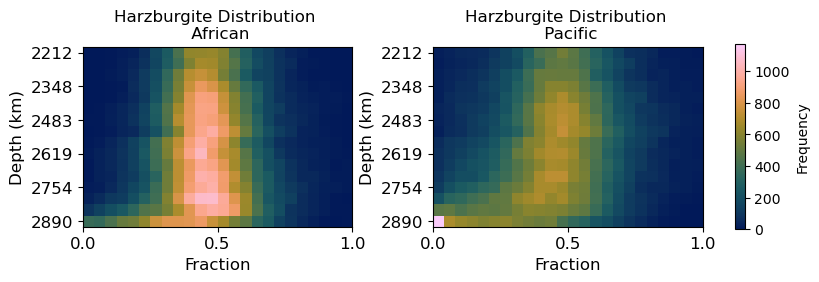

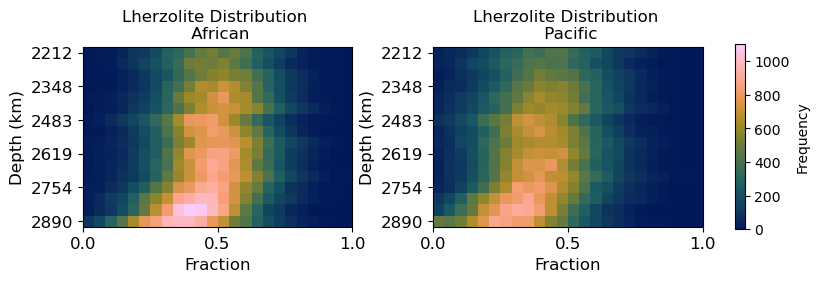

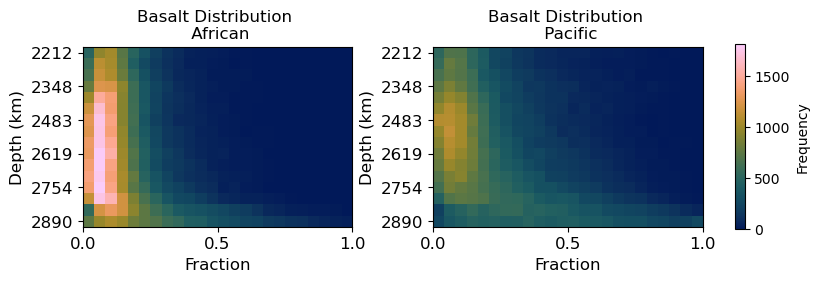

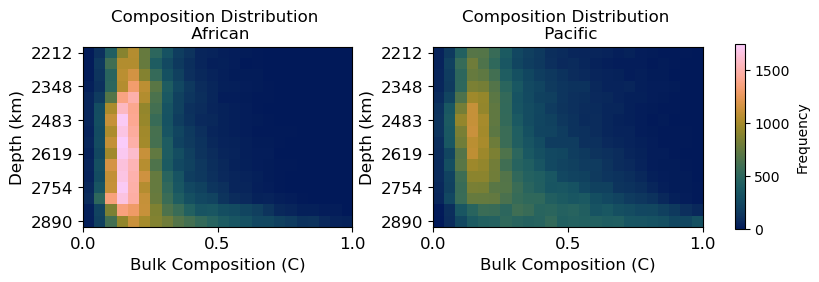

In [24]:
if ncomps==2 : compositions=["harzburgite","lherzolite","basalt","composition"]
if ncomps==3 : compositions=["harzburgite","lherzolite","basalt","primordial","composition"]
comp_hists=np.zeros((len(layers),nbins-1,2))
for composition in compositions:     
    for l,layer in enumerate(layers):
        depth=f"{str(int(depths[layer])).zfill(4)}"
        comp_hists[l,:,0]=obj['african'][depth][composition]['hist'][0]
        comp_hists[l,:,1]=obj['pacific'][depth][composition]['hist'][0]

    vmax=np.max(comp_hists[:,:,:])
    vmin=np.min(comp_hists[:,:,:])
    fig,ax=plt.subplots(figsize=(8,8),ncols=2)
    for i,domain in enumerate(obj.keys()):
        cnt=ax[i].imshow(comp_hists[:,:,i],vmin=vmin,vmax=vmax,cmap=batlow)

        ax[i].set_yticks(np.arange(0,len(layers),3),depths[layers][::3].astype(int))
        if composition=="composition":
            ax[i].set_xticks([0-0.5,(len(comp_hists[0,:,1])/2)-0.5,len(comp_hists[0,:,1])-0.5],
                         np.round(np.linspace(0,np.max(obj[domain]['2890']["composition"]['hist'][1]),3),1))
        else:
            ax[i].set_xticks([0-0.5,(len(comp_hists[0,:,1])/2)-0.5,len(comp_hists[0,:,1])-0.5],
                         np.linspace(0,1,3))  
        ax[i].set_ylabel("Depth (km)",fontsize=12)
        if composition == "composition":
            ax[i].set_xlabel("Bulk Composition (C)", fontsize=12)
        else:
            ax[i].set_xlabel("Fraction",fontsize=12)
        ax[i].set_title(f"{composition.capitalize()} Distribution \n {domain.capitalize()}")
        ax[i].tick_params(axis='both', which='major', labelsize=12)

    cbar=plt.colorbar(cnt,ax=ax[:],orientation='vertical',label=f'Frequency',shrink=0.3,anchor=(1.5,0.5))
    plt.subplots_adjust(wspace=0.3)
    plt.savefig(f"{case}/llsvp_{composition}_dist{prim_type}.png",format="png",dpi=150,bbox_inches="tight")

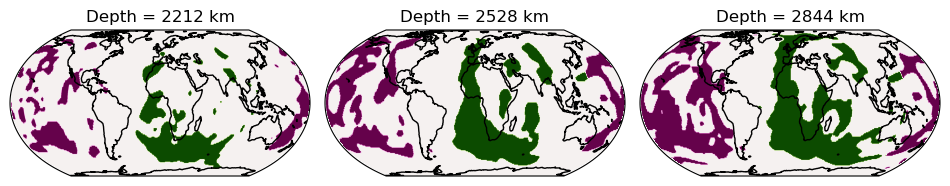

In [25]:
dss=['2212','2528','2844']
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.EqualEarth()},
                figsize=(12,12),ncols=3)
crs=ccrs.PlateCarree()
for i, ds in enumerate(dss):
    both=np.zeros((np.shape(obj['african'][ds]['mask'])[0],np.shape(obj['african'][ds]['mask'])[1]))
    both=both+obj['african'][ds]['mask']
    both=both+(-1*obj['pacific'][ds]['mask'])
        
    cnt1=ax[i].imshow(both,transform=crs,
                 cmap=bam)

    # gl1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
    #         linewidth=2, color='gray', alpha=0.5, linestyle='--')
    ax[i].coastlines()
    ax[i].set_title(f'Depth = {ds} km',fontsize=12)
plt.subplots_adjust(wspace=0.05)
plt.savefig(f"{case}/llsvp_outlines.png",format="png",dpi=300,bbox_inches="tight")
# plt.close()

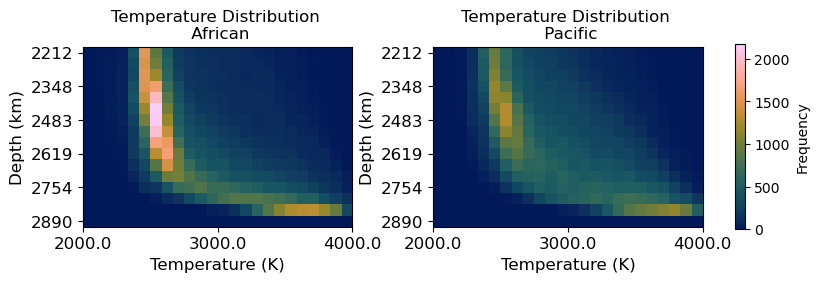

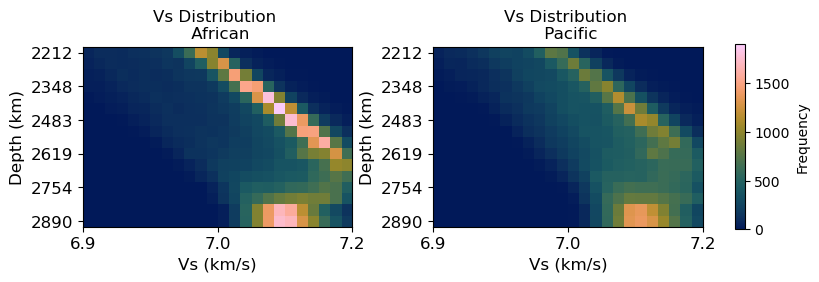

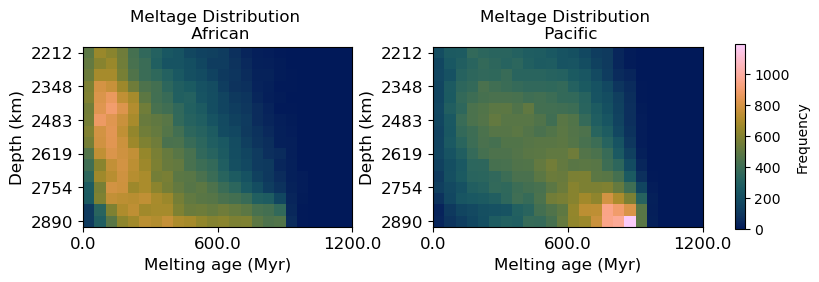

In [26]:
fields_to_plot=['temperature','vs','meltage'] # fields to plot
field_hists=np.zeros((len(layers),nbins-1,2))
for field in fields_to_plot:     
    for l,layer in enumerate(layers):
        depth=f"{str(int(depths[layer])).zfill(4)}"
        field_hists[l,:,0]=obj['african'][depth][field]['hist'][0]
        field_hists[l,:,1]=obj['pacific'][depth][field]['hist'][0]
        if field=='meltage':
            field_hists[l,:,0]=field_hists[l,::-1,0]
            field_hists[l,:,1]=field_hists[l,::-1,1]

    if field!='meltage':
        xticks=np.round(np.linspace(his_lims[field]["min"],his_lims[field]["max"],3),1)
        
        
    else:
        xticks=(his_lims[field]["max"]-np.round(np.linspace(his_lims[field]["min"],his_lims[field]["max"],3),1))/1e6
        xticks=np.flip((his_lims[field]["max"]-np.round(np.linspace(his_lims[field]["min"],his_lims[field]["max"],3),1))/1e6)

    vmax=np.max(field_hists[:,:,:])
    vmin=np.min(field_hists[:,:,:])
    fig,ax=plt.subplots(figsize=(8,8),ncols=2)
    for i,domain in enumerate(obj.keys()):
        
        cnt=ax[i].imshow(field_hists[:,:,i],vmin=vmin,vmax=vmax,cmap=batlow)

        ax[i].set_yticks(np.arange(0,len(layers),3),depths[layers][::3].astype(int))
        ax[i].set_xticks([0-0.5,(len(comp_hists[0,:,1])/2)-0.5,len(comp_hists[0,:,1])-0.5],
                         (xticks if field != 'meltage' else xticks[::-1]))  
        ax[i].set_ylabel("Depth (km)",fontsize=12)
        ax[i].set_xlabel(f"{field.capitalize()} ({units[field]['units']})" if field != 'meltage' else f"Melting age ({units[field]['units']})",fontsize=12)
        ax[i].set_title(f"{field.capitalize()} Distribution \n {domain.capitalize()}")
        ax[i].tick_params(axis='both', which='major', labelsize=12)

        if field=='meltage':
            ax[i].invert_xaxis()

    cbar=plt.colorbar(cnt,ax=ax[:],orientation='vertical',label=f'Frequency',shrink=0.3,anchor=(1.5,0.5))
    plt.subplots_adjust(wspace=0.3)
    plt.savefig(f"{case}/llsvp_{field}_dist{prim_type}.png",format="png",dpi=150,bbox_inches="tight")

composition [17.09050163 17.402323   20.64952837 22.09971552 23.49314036 22.96522058
 22.35736437 23.08470953 26.83526498 31.92421486 37.34851658 43.04316214
 50.12494382 53.20762687 48.52292958 46.28578734]
temperature [1.20471588e+00 1.21986164e+00 1.46912085e+00 2.07332733e+00
 2.50273822e+00 2.69751585e+00 2.95233075e+00 3.25006428e+00
 3.64567490e+00 3.80334507e+00 3.84668489e+00 3.53282569e+00
 2.85813581e+00 1.52963644e+00 8.04496236e-01 1.11213505e-14]
vs [-0.02650164 -0.02400637 -0.02708495 -0.05919208 -0.07898053 -0.09072874
 -0.10623023 -0.12453056 -0.12997101 -0.11421095 -0.12418639 -0.13233427
 -0.07360859  0.08590299  0.17808299  0.17298533]


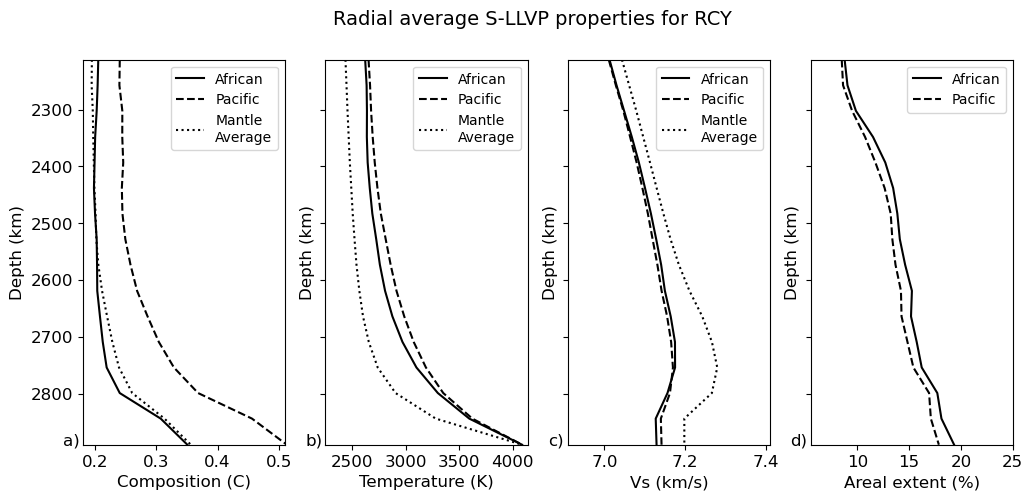

In [33]:
fields=['composition','temperature','vs'] # fields to plot
fig,ax = plt.subplots(figsize=(3*(len(fields)+1),5),ncols=len(fields)+1,sharey=True)

fix_xlims=True
xmins=[0.18, 2250, 6.91,  5.5]
xmaxs=[0.51, 4140, 7.41, 25]

case="RCY"
dump=37
abc_shift=0 #shift the lettering of figure panels
prim_type="" #leave as empty string if no prim material
mod=nc.Dataset(f'{case}/nc_seis_{str(dump).zfill(3)}{prim_type}.nc')
modcomp=nc.Dataset(f'{case}/nc_comp_{str(dump).zfill(3)}{prim_type}.nc')
ncomps=np.shape(mod["composition_fractions"])[1]
with (open(f"{case}/llsvps{prim_type}.pickle", "rb")) as openfile:
    obj=pickle.load(openfile)
    # obj=llsvps
    for i,field in enumerate(fields):
        rad=np.zeros((len(layers),3))
        if field=="composition" or field=='c':cfracs=np.zeros((len(layers),ncomps+1,2))
        for j,layer in enumerate(layers):
            depth=f"{str(int(depths[layer])).zfill(4)}"
            rad[j,0]=depth
            rad[j,1]=obj['african'][depth][field]['average']
            rad[j,2]=obj['pacific'][depth][field]['average']
            if field=="composition" or field=='c':
                for c in range(ncomps+1):
                    cname=getattr(mod["composition_fractions"],f"composition_{c+1}_name").lower()
                    cfracs[j,c,0]=obj['african'][depth][cname]['average']
                    cfracs[j,c,1]=obj['pacific'][depth][cname]['average']

        print(field,(rad[:,2]-rad[:,1])/rad[:,1]*100)

        ax[i].plot(rad[:,1],rad[:,0],label='African',c='black')
        ax[i].plot(rad[:,2],rad[:,0],'--',label='Pacific',c='black')
        ax[i].set_ylim(np.max(rad[:,0]),np.min(rad[:,0]))
        ax[i].set_ylabel('Depth (km)',fontsize=12)
        if fix_xlims: ax[i].set_xlim(xmins[i],xmaxs[i])
        ax[i].set_xlabel(f'{field.capitalize()} ({units[field]["units"]})',fontsize=12)
        ax[i].tick_params(axis='both', which='major', labelsize=12)


        if field=="composition" or field=="c":
            av_c=np.zeros(len(mod["depths"]))
            for r in range(len(mod["depths"])):
                av_c[r]=np.average(get_cvals(mod["composition_fractions"],r))
            ax[i].plot(av_c[-len(rad):],rad[:,0],':',label='Mantle\nAverage',c='black')
        elif field=="density":
            av_t=np.zeros(len(mod["depths"]))
            for r in range(len(mod["depths"])):
                av_t[r]=np.average(modcomp[field][:,r,:])
            ax[i].plot(av_t[-len(rad):],rad[:,0],':',label='Mantle\nAverage',c='black')
        else:
            av_t=np.zeros(len(mod["depths"]))
            for r in range(len(mod["depths"])):
                av_t[r]=np.average(mod[field][:,r,:])
            ax[i].plot(av_t[-len(rad):],rad[:,0],':',label='Mantle\nAverage',c='black')


        ax[i].legend()
        xlims=ax[i].get_xlim()
        ylims=ax[i].get_ylim()
        ax[i].text(xlims[0]-((xlims[1]-xlims[0])/10),ylims[0],f'{alphabet[abc_shift+i]})',fontsize=12)

    a_frac=np.zeros((len(layers),3))
    for j,layer in enumerate(layers):
        depth=f"{str(int(depths[layer])).zfill(4)}"
        a_frac[j,0]=depth
        a_frac[j,1]=obj['african'][depth]['area_frac']
        a_frac[j,2]=obj['pacific'][depth]['area_frac']
    ax[-1].plot(a_frac[:,1]*100,a_frac[:,0],label='African',c='black')
    ax[-1].plot(a_frac[:,2]*100,a_frac[:,0],'--',label='Pacific',c='black')


ax[-1].legend()
ax[-1].set_ylim(np.max(rad[:,0]),np.min(rad[:,0]))
if fix_xlims: ax[-1].set_xlim(xmins[-1],xmaxs[-1])
ax[-1].set_ylabel('Depth (km)',fontsize=12)
ax[-1].set_xlabel(f'Areal extent (%)',fontsize=12)
xlims=ax[-1].get_xlim()
ylims=ax[-1].get_ylim()
ax[-1].text(xlims[0]-((xlims[1]-xlims[0])/10),ylims[0],f'{alphabet[abc_shift+i+1]})',fontsize=12)
ax[-1].tick_params(axis='both', which='major', labelsize=12)
    
# fig.suptitle(f"Radial average S-LLVP properties for {case}{prim_type}",fontsize=14)
fig.suptitle(f"Radial average S-LLVP properties for {case}",fontsize=14)
plt.savefig(f"{case}/llsvps_radial{prim_type}.png",format="png",dpi=200,bbox_inches="tight")